In [52]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import seaborn as sns
import datetime as dt

sns.set_palette(sns.color_palette('colorblind', 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
fig_format = 'jpg'
dpi = 1000
figsize = (12, 6.5)
figsize_map = (6.5, 6.5)
sns.set_style('whitegrid')

In [53]:
path = r'/Users/macintosh/Documents/OneDrive - Cardiff University/04 - Projects/99 - Misc/data science task SSE'
file = 'data.csv'

In [54]:
df = pd.read_csv(path+os.path.sep+file, index_col = 0)

In [55]:
df.head()

,TYPE,0,DATE,TIME
0,DEMANDDATA,7.464297,01/01/2021,00:00:00
1,WIND,30.520000,01/01/2021,00:00:00
2,CHP,0.000000,01/01/2021,00:00:00
3,IMPORT,-999999.000000,01/01/2021,00:00:00
4,EXPORT,23.055703,01/01/2021,00:00:00


In [56]:
def log_time_shape(func):
    def wrapper(dataf, *args, **kwargs):
        time_start = dt.datetime.now()
        result = func(dataf, *args, **kwargs)
        time_end = dt.datetime.now()
        print(f"{func.__name__} took {time_end-time_start} shape={result.shape}")
        return result
    return wrapper


@log_time_shape
def start_pipeline(dataf):
    return dataf.copy()

@log_time_shape
def rearrange_data(dataf):
    dataf = pd.pivot_table(dataf, values='0', columns=['TYPE'], index = ['FULL_DATE'], aggfunc=np.sum)
    dataf.sort_index(inplace=True)
    return dataf

@log_time_shape
def add_missing_datetimeindex(dataf, time_res = '30min'):
    # add missing index values to the dataf
    new_dataf = pd.DataFrame()
    new_dataf["Index"] = pd.date_range(start=dataf.index[0], end=dataf.index[-1], freq=time_res)
    new_dataf.set_index("Index", inplace=True)
    
    return new_dataf.merge(dataf, left_index=True, right_index=True, how='left')

@log_time_shape
def create_time_index(dataf):  
    dataf['NEW_DATE'] = pd.to_datetime(dataf['DATE'], format='%d/%m/%Y', errors='coerce')
    dataf['NEW_DATE'].fillna(pd.to_datetime(dataf['DATE'], format='%m/%d/%Y', errors='coerce'), inplace=True)
    dataf['FULL_DATE'] = dataf['NEW_DATE'].astype(str).str.cat(df['TIME'], sep=' ')
    dataf['FULL_DATE'] = pd.to_datetime(dataf['FULL_DATE'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    return dataf

def get_season(row):
    if row['Month'] >= 4 and row['Month'] <= 5: #April and May
        return 'Spring'
    elif row['Month'] >= 6 and row['Month'] <= 6: # June
        return 'Summer'
    elif row['Month'] >= 7 and row['Month'] <= 8: # July and August
        return 'High Summer'
    elif row['Month'] >= 9 and row['Month'] <= 10: # September and October
        return 'Autumn'
    else:
        return 'Winter'

@log_time_shape
def add_time_features(dataf):
    season_dict = {'Winter':1, 'Spring':2, 'Summer':3, 'High Summer':4, 'Autumn':5}
    dataf['Hour'] = dataf.index.hour
    dataf['Day_of_week']= dataf.index.dayofweek
    dataf['Day']= dataf.index.dayofyear
    dataf['Month'] =dataf.index.month
    dataf['Year'] =dataf.index.year
    dataf['Weekday_flag'] = [1 if x<5 else 0 for x in dataf.index.dayofweek]
    dataf['HH'] = dataf.index.hour*2+dataf.index.minute//30
    dataf['HH'] = dataf['HH'].astype(int)
    dataf['Date'] = dataf.index.date
    dataf['Week'] = dataf.index.isocalendar().week
    dataf['Season'] = dataf.apply(get_season, axis=1)
    dataf['Season_num'] = dataf['Season']
    dataf.replace({'Season_num':season_dict}, inplace=True)
    return dataf

@log_time_shape 
def fill_solar_data(dataf):
    dataf['SOLAR'].fillna(0, inplace=True)
    return dataf

@log_time_shape    
def fill_missing_data(dataf):
    dataf.fillna(dataf.interpolate(), inplace=True)
    return dataf

@log_time_shape
def remove_outliers(dataf):
    for c in dataf.columns:
        std_vals = (dataf[c]
                    .rolling(48, center=True, min_periods=48)
                    .std()
                    .fillna(method='bfill')
                    .fillna(method='ffill'))
        mean_vals = (dataf[c]
                     .rolling(48, center=True, min_periods=48)
                     .mean()
                     .fillna(method='bfill')
                     .fillna(method='ffill'))

        dataf.loc[dataf[c].abs() > mean_vals+3*std_vals,c] = np.nan

    idx_to_keep = dataf[['CHP', 'DEMANDDATA', 'WIND', 'SOLAR']].dropna(how='any', axis=0).index
    dataf = dataf.loc[idx_to_keep]
    return dataf

@log_time_shape
def add_electricity_prices(dataf):
    # - 01/04- 30/09
    # - M-F, 8-5, 52 £/MWH
    # - M-F, 5-20, 64 £/MWH
    # - M-F, other, 43 £/MWH
    # - S-S, other, 40 £/MWH
    dataf['Export_price_GBP/MWh'] = 0
    period_filter_1 = (dataf.index >= '2021-04-01') & (dataf.index <= '2021-09-30')
    dataf.loc[period_filter_1, 'Export_price_GBP/MWh'] = 43
    dataf.loc[(
        period_filter_1
        & (dataf['Day_of_week'] < 5) 
        & ((dataf['Hour'] >= 20)
        | (dataf['Hour'] < 5))),
        'Export_price_GBP/MWh'] = 52
    
    dataf.loc[(
        period_filter_1
        & (dataf['Day_of_week'] < 5) 
        & (dataf['Hour'] >= 5)
        & (dataf['Hour'] < 20)),
        'Export_price_GBP/MWh'] = 64
    
    dataf.loc[(
        period_filter_1
        & (dataf['Day_of_week'] >= 5)),
        'Export_price_GBP/MWh'] = 40
    
    # - 1/10 - 31/03
    # - M-F, 8-5, 63 £/MWH
    # - M-F, 5-20, 74 £/MWH
    # - M-F, other, 51 £/MWH
    # - S-S, other, 50 £/MWH
    
    period_filter_2 = ((dataf.index < '2021-04-01')
                    | (dataf.index > '2021-09-30'))
    dataf.loc[period_filter_2, 'Export_price_GBP/MWh'] = 51
    dataf.loc[period_filter_2 
              & (dataf['Day_of_week'] < 5) 
              & ((dataf['Hour'] >= 20)
              | (dataf['Hour'] < 5)),
              'Export_price_GBP/MWh'] = 63
    dataf.loc[period_filter_2
              & (dataf['Day_of_week'] < 5) 
              & (dataf['Hour'] >= 5)
              & (dataf['Hour'] < 20),
             'Export_price_GBP/MWh'] = 74
    dataf.loc[period_filter_2 
              & (dataf['Day_of_week'] >= 5),
              'Export_price_GBP/MWh'] = 50
    
    dataf['Import_price_GBP/MWh'] = dataf['Export_price_GBP/MWh'] + 1
    return dataf

def calculate_import_export(dataf):
    dataf['EXPORT'] = dataf['SOLAR']+dataf['WIND']+dataf['CHP']-dataf['DEMANDDATA']
    dataf.loc[dataf['EXPORT']<0, 'EXPORT'] = 0
    dataf['IMPORT'] = dataf['DEMANDDATA'] - (dataf['SOLAR']+dataf['WIND']-dataf['EXPORT']+dataf['CHP'])
    dataf.loc[dataf['IMPORT']<0, 'IMPORT'] = 0
    return dataf   

def calculate_cost_revenue(dataf):
    dataf['Import_cost_GBP'] = dataf['IMPORT'] * dataf['Import_price_GBP/MWh']/1000
    dataf['Export_revenue_GBP'] = -dataf['EXPORT'] * dataf['Export_price_GBP/MWh']/1000
    return dataf

def remove_CHP(dataf):
    max_chp_output = dataf['CHP'].max()/2 #kWh
    dataf.loc[dataf['CHP']>max_chp_output, 'CHP'] = max_chp_output
    return dataf

def minimise_import(dataf): #trying to minimise import of electricity
    max_chp_output = dataf['CHP'].max()
    dataf['CHP'] = dataf['DEMANDDATA'] - (dataf['SOLAR']+dataf['WIND'])
    dataf['CHP'] = dataf['CHP'].clip(lower = 0, upper = max_chp_output)
    return dataf

def no_CHP(dataf): 
    dataf['CHP'] = 0
    return dataf

def flatout_CHPs(dataf):
    dataf['CHP'] = dataf['CHP'].max()
    return dataf
    
def peaktime_CHPs(dataf):
    dataf.loc[(
        (dataf['Day_of_week'] < 5) 
        & (dataf['Hour'] >= 5)
        & (dataf['Hour'] < 20)),
        'CHP'] = dataf['CHP'].max()
    return dataf

def plot_average_week(dataf, target, func='mean', quantiles=True):
    fig, ax = plt.subplots(figsize=figsize)
    to_plot_df = (dataf
                  .groupby(['Day_of_week', 'HH'])
                  .agg(current = (target,func),
                       max = (target, 'max'),
                       min = (target, 'min'))           
                  # .unstack(0)
                  .reset_index(drop=True)
                  .dropna(axis=1))
    to_plot_df['current'].plot(ax=ax)
    y1 = to_plot_df['min'].values
    y2 = to_plot_df['max'].values
    ax.fill_between(np.arange(len(to_plot_df)), 
                    y1, 
                    y2, 
                    color=sns.color_palette()[0],
                    alpha=0.2)
    ax.set_ylabel(f'{target} (kWh)')
    ax.set_xlabel('Half-hour periods')

    ax.margins(0, None)
    if to_plot_df.mean().mean()<10:
        ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.2f}'.format(x)))
    else:
        ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
    return fig, ax

def plot_annual_data(dataf, cols=[], chart_type='bar'):
    fig, ax = plt.subplots(figsize=figsize)
    if len(cols)==0:
        cols = ['CHP', 'DEMANDDATA', 'EXPORT', 'IMPORT', 'SOLAR', 'WIND']
    if chart_type == 'bar':
        dataf[cols].sum().plot.bar(ax=ax)
    elif chart_type == 'line':
        dataf[cols].plot(ax=ax)
        ax.set_title(cols)
    else:
        raise ValueError(f'The {chart_type} is not recognized.') 
        
    ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
    ax.set_ylabel('Energy (kWh)')
    return fig, ax


def plot_cost_revenue(dataf):
    fig, ax = plt.subplots(figsize=figsize)
    dataf[['Import_cost_GBP', 'Export_revenue_GBP']].sum().plot.bar(ax=ax, rot=0)
    import_cost = dataf['Import_cost_GBP'].sum()
    export_revenue = dataf['Export_revenue_GBP'].sum()
    print(f'Import cost ({import_cost}) - export revenue ({export_revenue}) = {import_cost+export_revenue} GBP')
    ax.set_ylabel('Expenditure (GBP)')
    ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
    return fig, ax



## Clean df analysis

In [57]:
clean_df = (df
            .pipe(start_pipeline)
            .pipe(create_time_index)
            .pipe(rearrange_data)
            .pipe(fill_solar_data)
            .pipe(remove_outliers)
            .pipe(add_missing_datetimeindex)
            .pipe(fill_missing_data)
            .pipe(add_time_features)
            .pipe(add_electricity_prices)
            .pipe(calculate_import_export)
            .pipe(calculate_cost_revenue)
           )

start_pipeline took 0:00:00.001892 shape=(96639, 4)
create_time_index took 0:00:00.811517 shape=(96639, 6)
rearrange_data took 0:00:00.055001 shape=(17515, 6)
fill_solar_data took 0:00:00.001005 shape=(17515, 6)
remove_outliers took 0:00:00.020619 shape=(17404, 6)
add_missing_datetimeindex took 0:00:00.004182 shape=(17520, 6)
fill_missing_data took 0:00:00.007559 shape=(17520, 6)
add_time_features took 0:00:00.522681 shape=(17520, 17)
add_electricity_prices took 0:00:00.006775 shape=(17520, 19)


<AxesSubplot:xlabel='Index'>

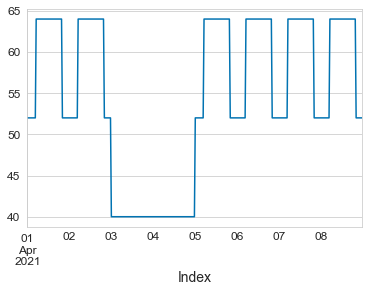

In [58]:
#Example of a week based on the first of export price 01/04- 30/09
clean_df.loc['2021-04-01':'2021-04-08', 'Export_price_GBP/MWh'].plot()

<AxesSubplot:xlabel='Index'>

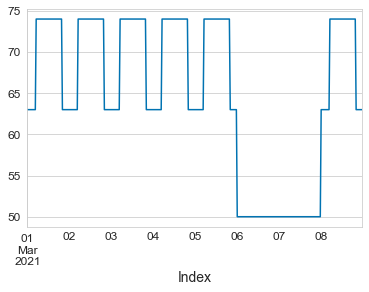

In [59]:
#Example of a week based on the first of export price 1/10 - 31/03
clean_df.loc['2021-03-01':'2021-03-08', 'Export_price_GBP/MWh'].plot()

(<Figure size 864x468 with 1 Axes>, <AxesSubplot:ylabel='Energy (kWh)'>)

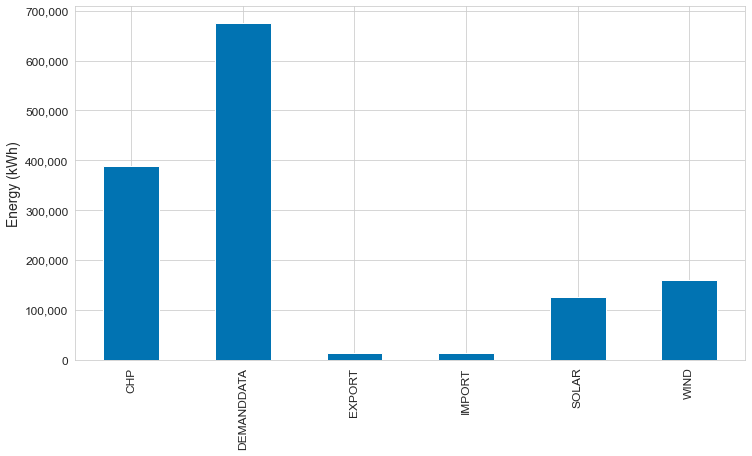

In [60]:
plot_annual_data(clean_df)

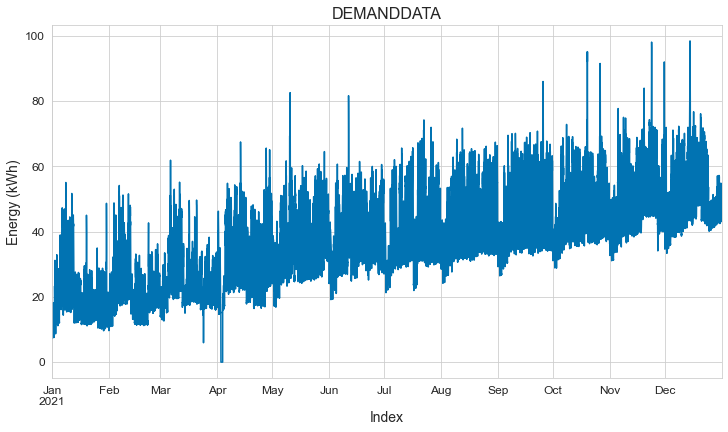

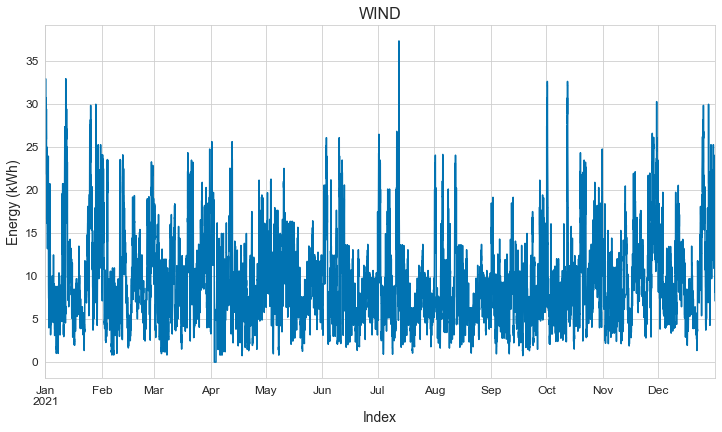

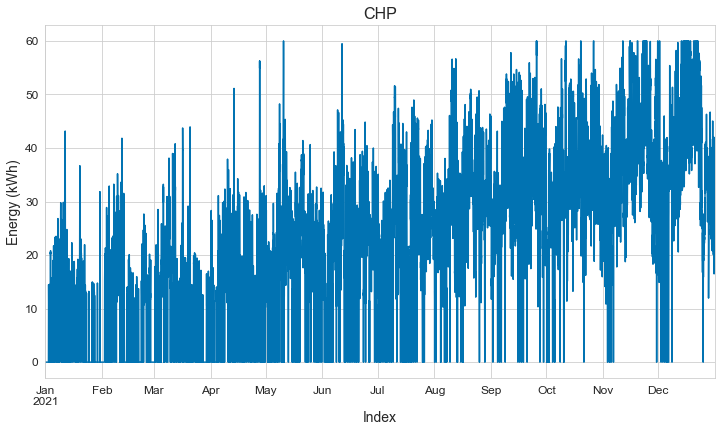

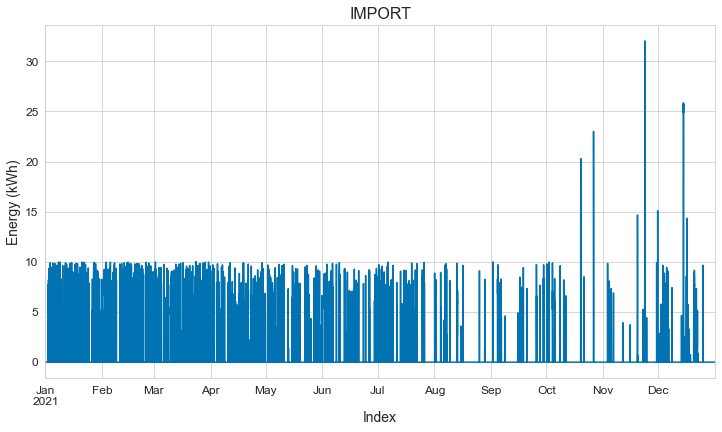

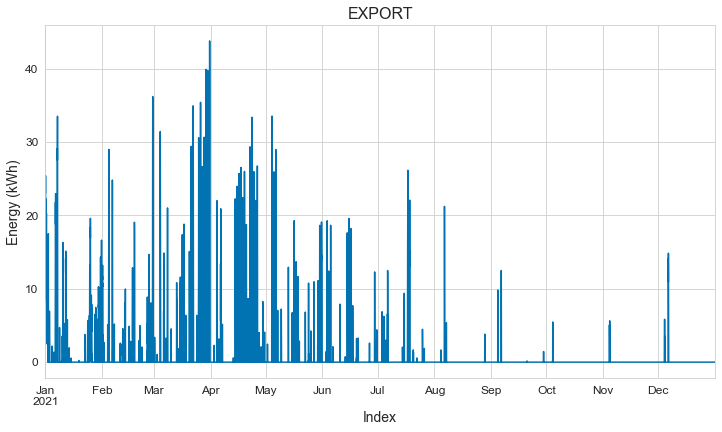

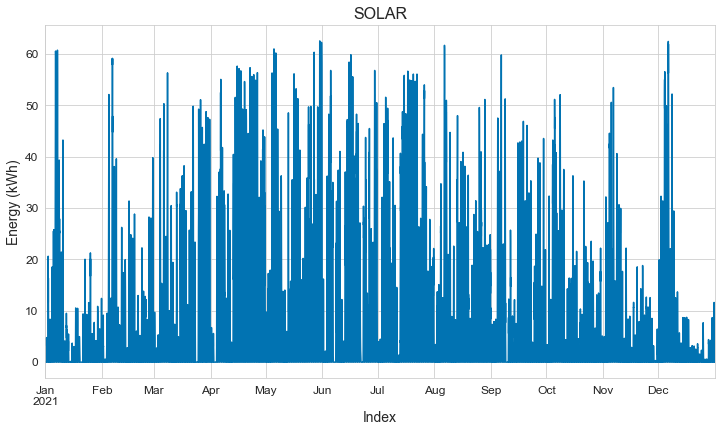

In [61]:
for c in df['TYPE'].unique():
    f, ax = plot_annual_data(clean_df, c, 'line')

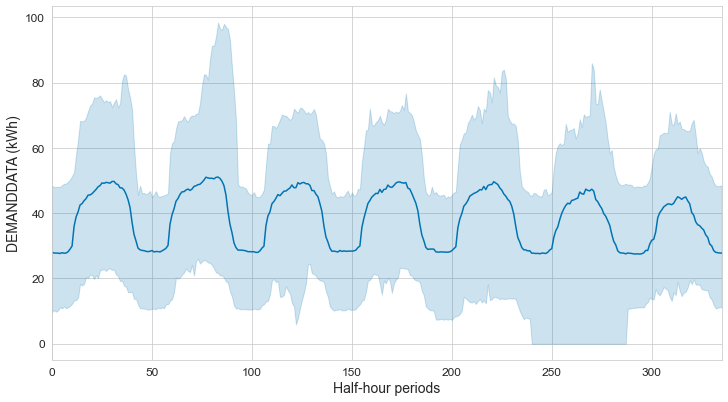

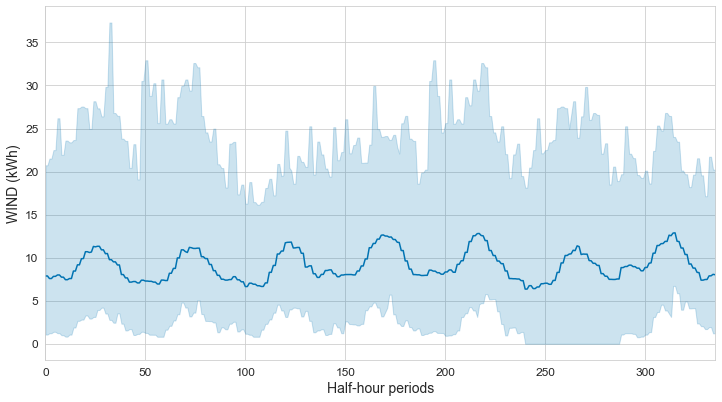

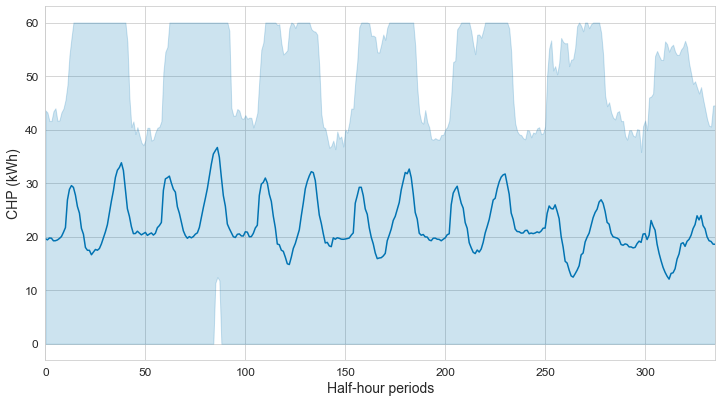

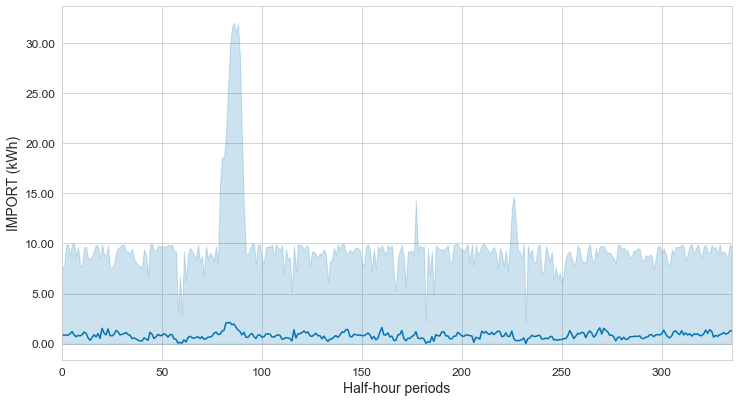

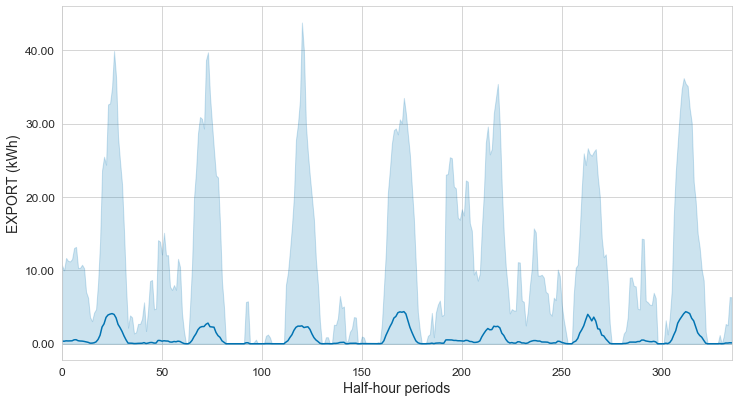

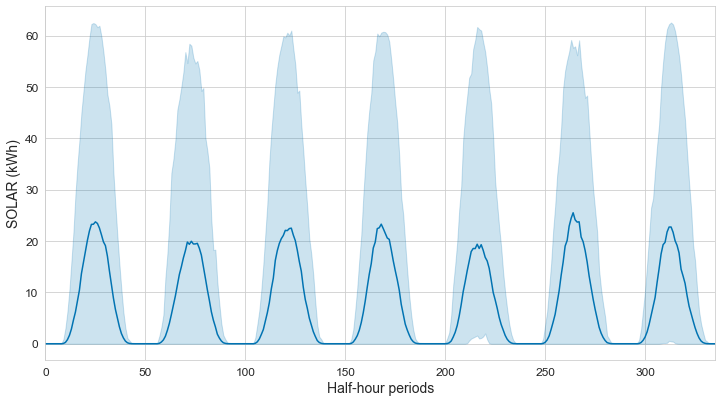

In [62]:
for c in df['TYPE'].unique():
    f, ax = plot_average_week(clean_df, c)

Import cost (890.6494317184229) - export revenue (-860.454006791666) = 30.195424926756914 GBP


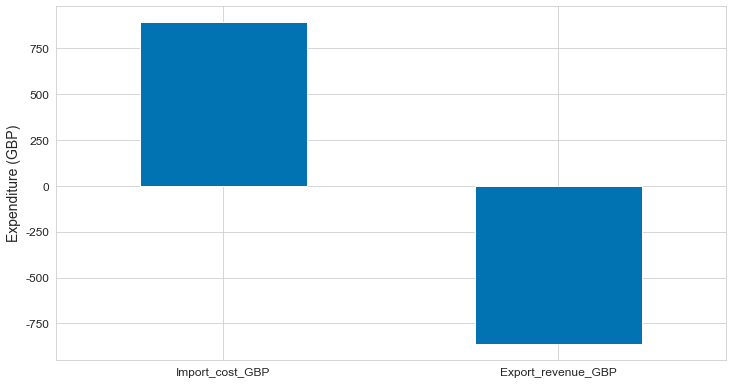

In [63]:
f, ax = plot_cost_revenue(clean_df)

## Single CHP generator
The powerplant consists of two equally sized gas generators, next year the customer would like to remove one of the gas generators due to it's age and increased emissions.
- The likely change in cost for this for 2022


The assumption is that there are two CHP generators of 60 kW each, if only one CHP generator remains the max generation will be 60 kW or 30 kWh/hh.

In [64]:
single_CHP_df = (clean_df
                 .pipe(start_pipeline)
                 .pipe(remove_CHP)
                 .pipe(calculate_import_export)
                 .pipe(calculate_cost_revenue)
                )

start_pipeline took 0:00:00.000893 shape=(17520, 21)


(<Figure size 864x468 with 1 Axes>, <AxesSubplot:ylabel='Energy (kWh)'>)

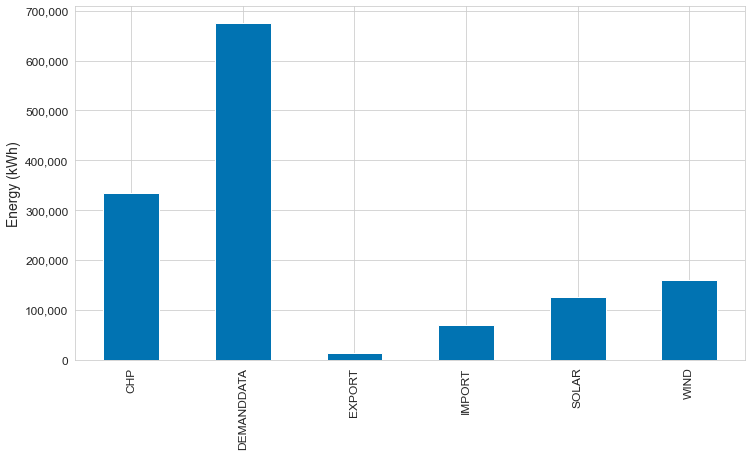

In [65]:
plot_annual_data(single_CHP_df)

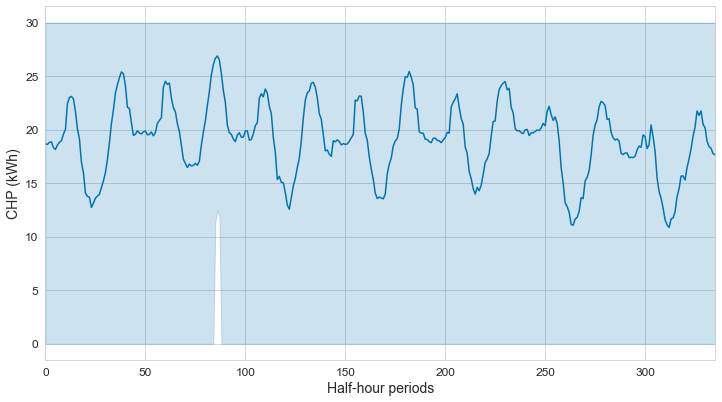

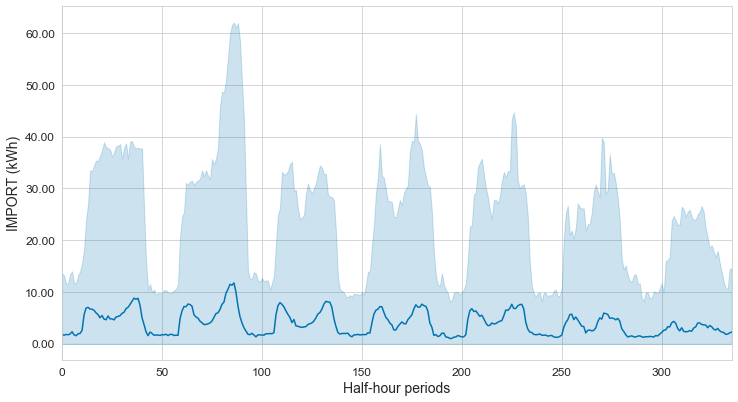

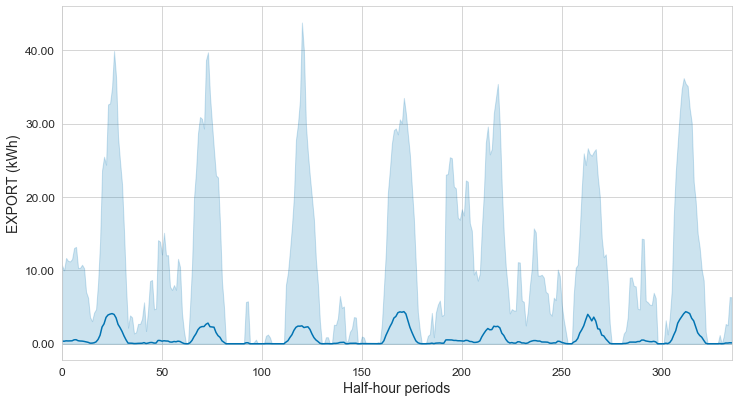

In [66]:
for c in ['CHP', 'IMPORT', 'EXPORT']:
    f, ax = plot_average_week(single_CHP_df, c)

Import cost (4542.186617355436) - export revenue (-860.4540067531996) = 3681.7326106022365 GBP


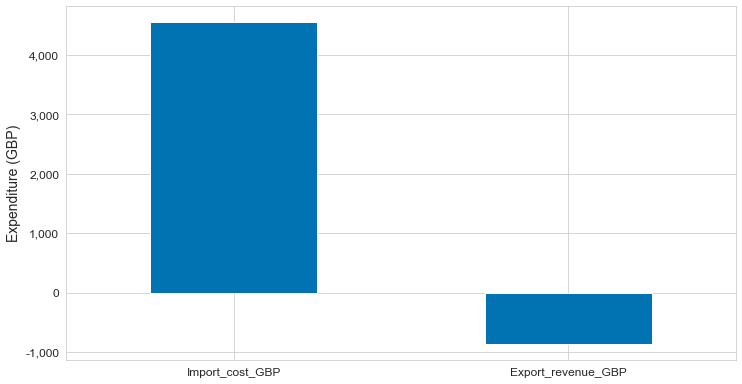

In [67]:
f, ax = plot_cost_revenue(single_CHP_df)

# How to increase profitability?

Further data is required to make any decision (spark price, heating demand ,etc.). Based on the spark price, different strategies are possible:

1. Case 1: import price > CHP electricity price > export price: only use CHP generators to supply on-site electricity demand
2. Case 2: CHP electricity price > import price > export price: minimise the use of CHP generators
3. Case 3: import price > export price > CHP electricity price: maximise the use of CHP generators

Case 1, 2 and 3 can be combined with other rules based on SOLAR and WIND prices.

4. Case 4: import price > SOLAR/WIND price > export price: try to shift the demand to maximise the use of on-site wind and solar generation. This could mean decrease the use of CHP generators to avoid wind/solar export depending on the spark price for the CHP generators. 
5. Case 5: import price > export price > SOLAR/WIND price: try to shift the demand to maximise the use of on-site wind and solar generation to minimise import. 

Instead of a rule based system, an optimisation problem can be solved which will aim to minimise total cost expenditure based on generation cost of SOLAR, WIND and CHP, electricity import and export prices

Other possibilities:
- energy storages (e.g, batteries, thermal storage, etc.)
- decrease the electricity demand/increase efficiency of the system


## Case 1: minimise import

In [68]:
minimise_import_df = (clean_df
                   .pipe(start_pipeline)
                   .pipe(minimise_import)
                   .pipe(calculate_import_export)
                   .pipe(calculate_cost_revenue)
                  )

start_pipeline took 0:00:00.002108 shape=(17520, 21)


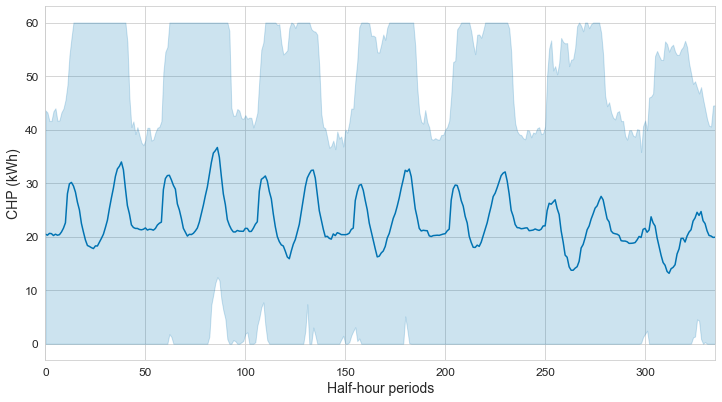

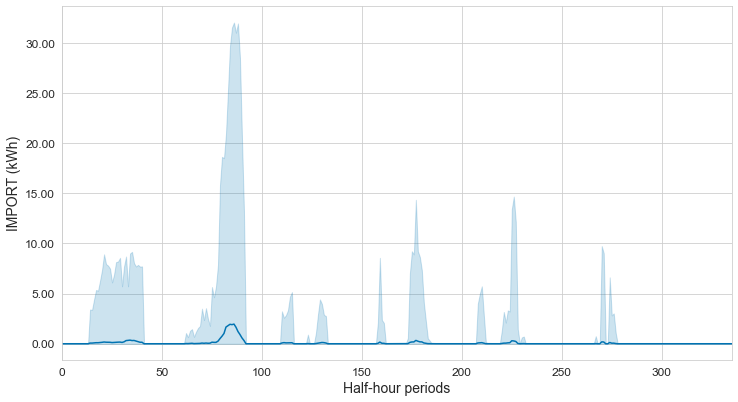

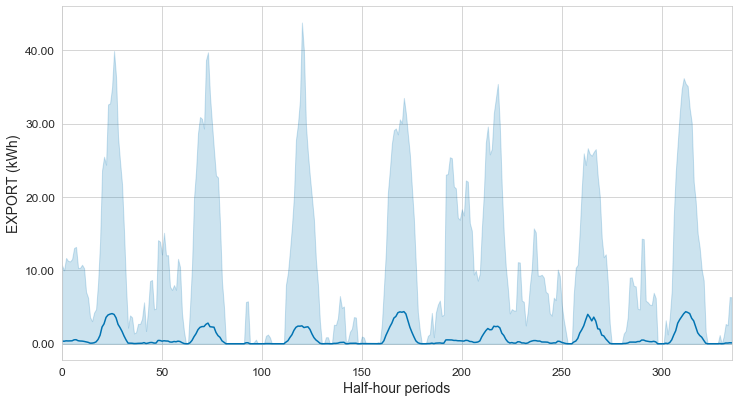

In [69]:
for c in ['CHP', 'IMPORT', 'EXPORT']:
    f, ax = plot_average_week(minimise_import_df, c)

Import cost (103.70181147894024) - export revenue (-860.4540066687015) = -756.7521951897612 GBP


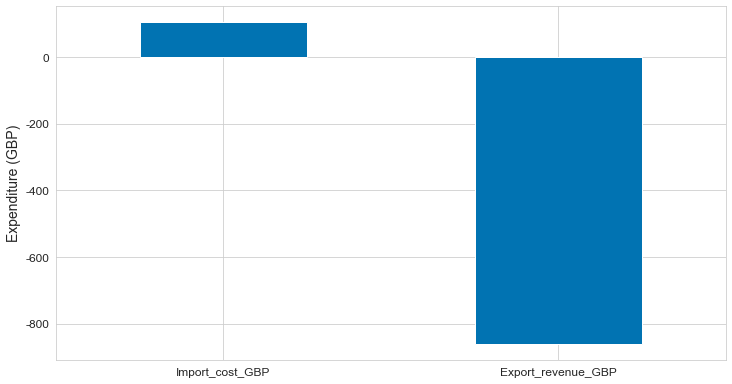

In [70]:
f, ax = plot_cost_revenue(minimise_import_df)

## Case 2: minimise the use of CHP generators

In [71]:
no_CHP_df = (clean_df
                   .pipe(start_pipeline)
                   .pipe(no_CHP)
                   .pipe(calculate_import_export)
                   .pipe(calculate_cost_revenue)
                  )

start_pipeline took 0:00:00.001474 shape=(17520, 21)


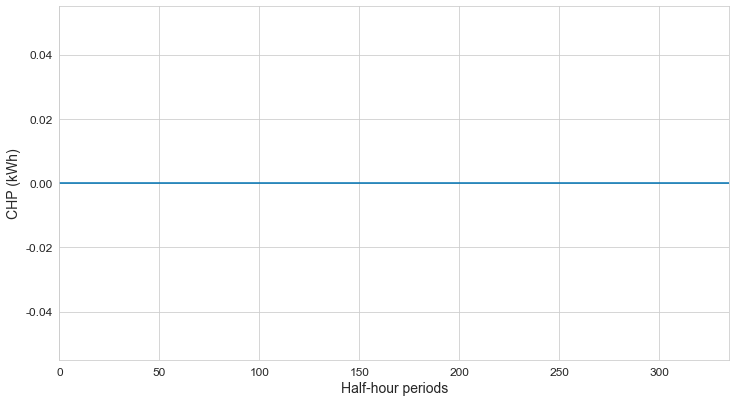

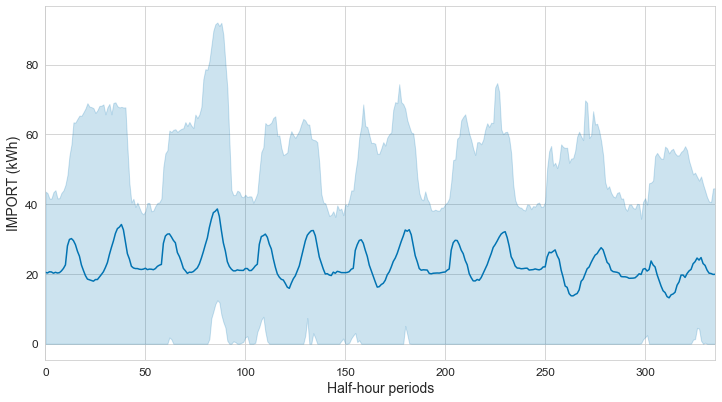

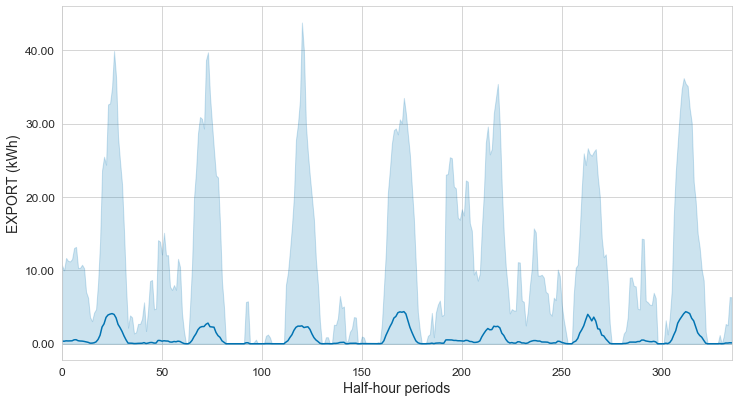

In [72]:
for c in ['CHP', 'IMPORT', 'EXPORT']:
    f, ax = plot_average_week(no_CHP_df, c)

Import cost (24657.68413537244) - export revenue (-860.4540066687013) = 23797.23012870374 GBP


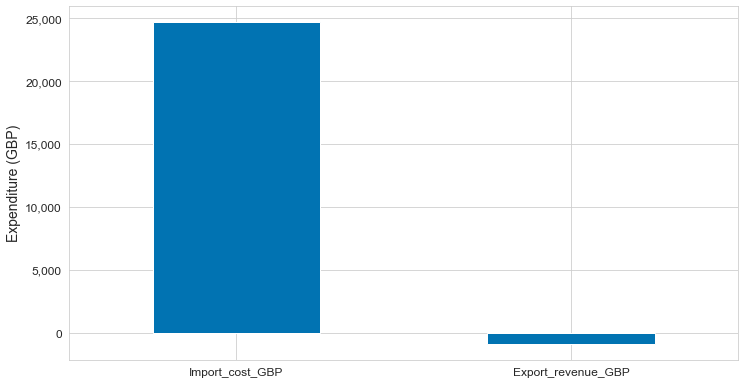

In [73]:
f, ax = plot_cost_revenue(no_CHP_df)

## Case 3: maximise use of CHP generators

In [74]:
# Run the CHP generators to their maximum capacity all the time
flatout_chps_df = (clean_df
                   .pipe(start_pipeline)
                   .pipe(flatout_CHPs)
                   .pipe(calculate_import_export)
                   .pipe(calculate_cost_revenue)
                  )

start_pipeline took 0:00:00.000886 shape=(17520, 21)


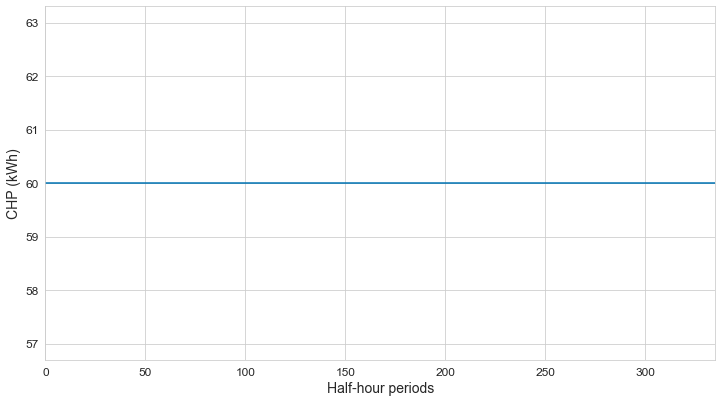

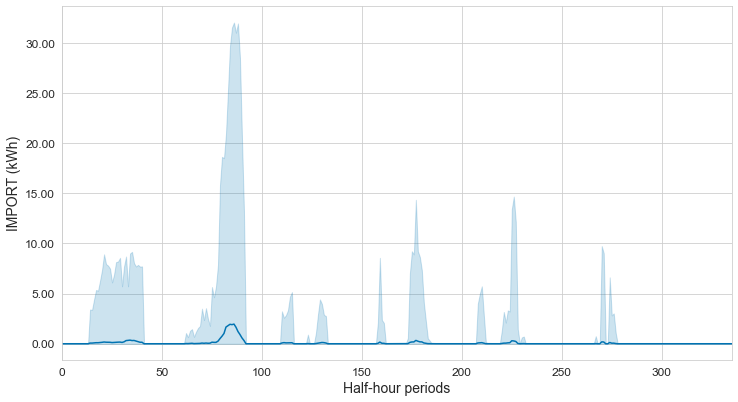

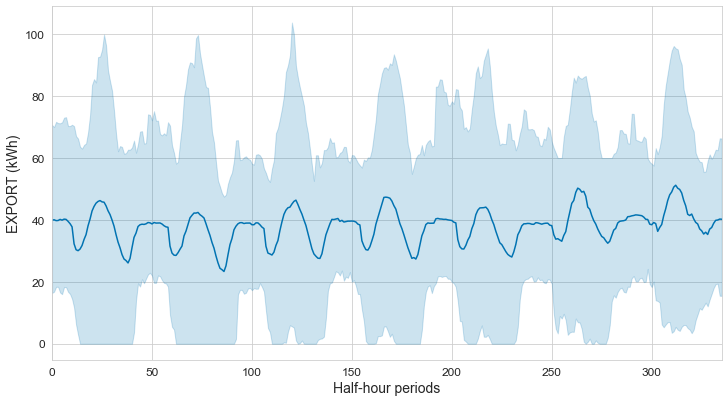

In [75]:
for c in ['CHP', 'IMPORT', 'EXPORT']:
    f, ax = plot_average_week(flatout_chps_df, c)

Import cost (103.70181147894179) - export revenue (-38825.71285554755) = -38722.01104406861 GBP


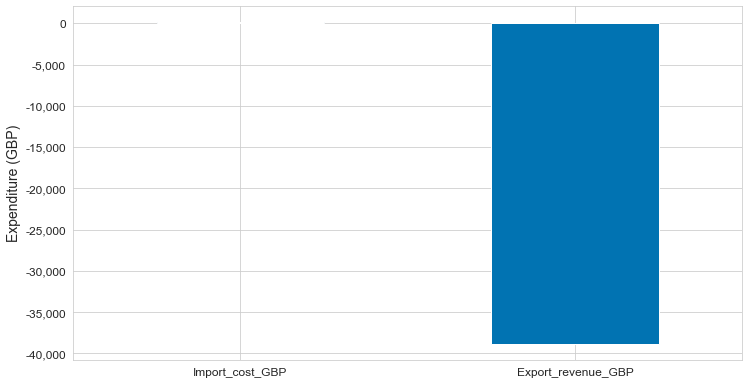

In [76]:
f, ax = plot_cost_revenue(flatout_chps_df)

## Case 4 and 5
if electricity price import > on-site wind and solar electricity price generationthe goal is to maximise the use of on-site wind and solar generation by shifting the demand from mid-day to morning or late afternoon.

Text(0, 0.5, 'Energy')

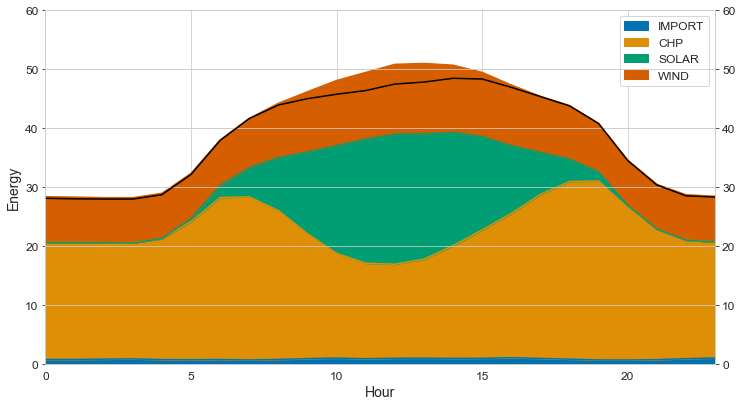

In [77]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
clean_df.groupby('Hour').mean()['DEMANDDATA'].plot(ax=ax2, color='black')
clean_df.groupby('Hour').mean()[['IMPORT','CHP', 'SOLAR', 'WIND']].plot.area(stacked=True, ax=ax)
ax.set_ylim(0, 60)
ax2.set_ylim(0, 60)
ax.margins(0, None)
ax.set_ylabel('Energy')